<a href="https://colab.research.google.com/github/Dhanashripalde13/Codsoft-internship/blob/main/Codsoft_Movie_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
train_data = pd.read_csv("train_data.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
test_data = pd.read_csv("test_data.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_data.head()

,Title,Genre,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [4]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)
data = combined_data

In [5]:
data = data.dropna()
corpus = data["Description"].apply(lambda x: re.findall(r'\w+', x.lower()))
word2vec_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence):
    words = re.findall(r'\w+', sentence.lower())
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * 100

data["embeddings"] = data["Description"].apply(get_sentence_embedding)
X = pd.DataFrame(data["embeddings"].to_list())

label_encoder = LabelEncoder()
data["genre_encoded"] = label_encoder.fit_transform(data["Genre"])
y = data["genre_encoded"]

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


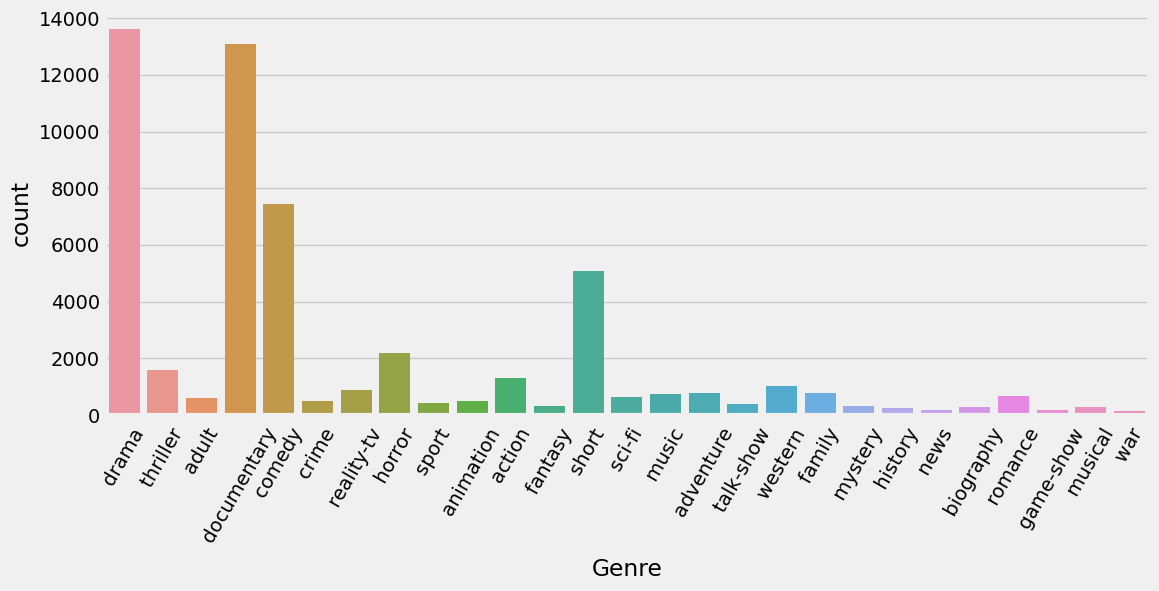

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
sns.countplot(x=train_data['Genre'])    # Count of number of descriptions for each class label
plt.xticks(rotation=60)
plt.show()

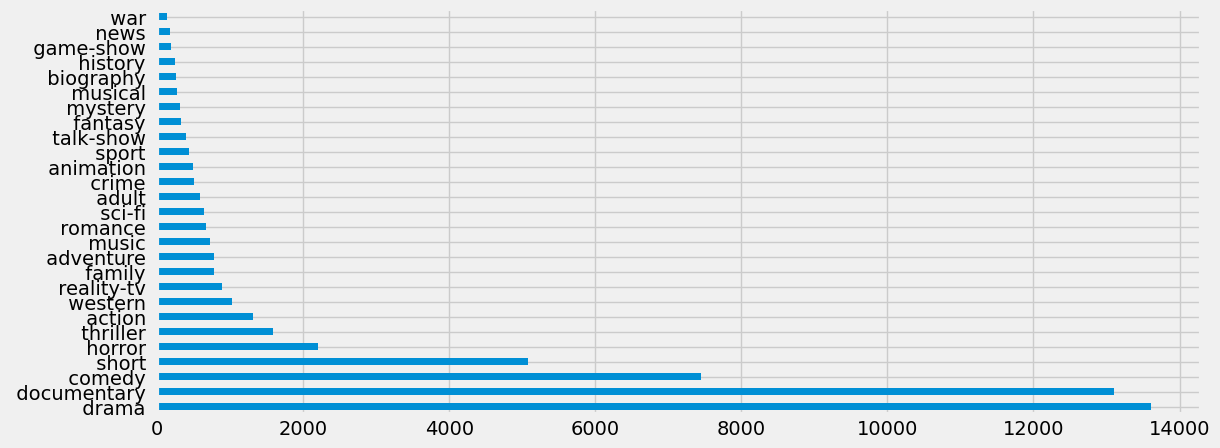

In [8]:
plt.figure(figsize=(12,5))
train_data['Genre'].value_counts().plot.barh()
plt.show()

In [9]:
train_data['description length']=train_data['Description'].apply(lambda x:len(x))   # calculating length of description for each row
train_data.head()

,Title,Genre,Description,description length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


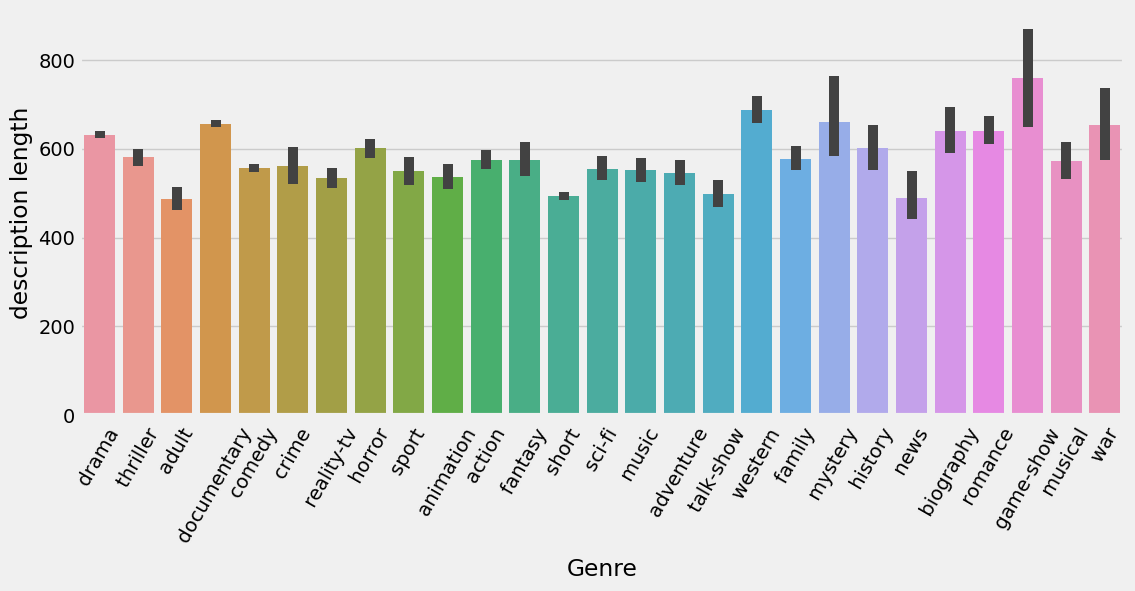

In [10]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre',y='description length',data=train_data)   # average length and its deviation for all classes
plt.xticks(rotation=60)
plt.show()

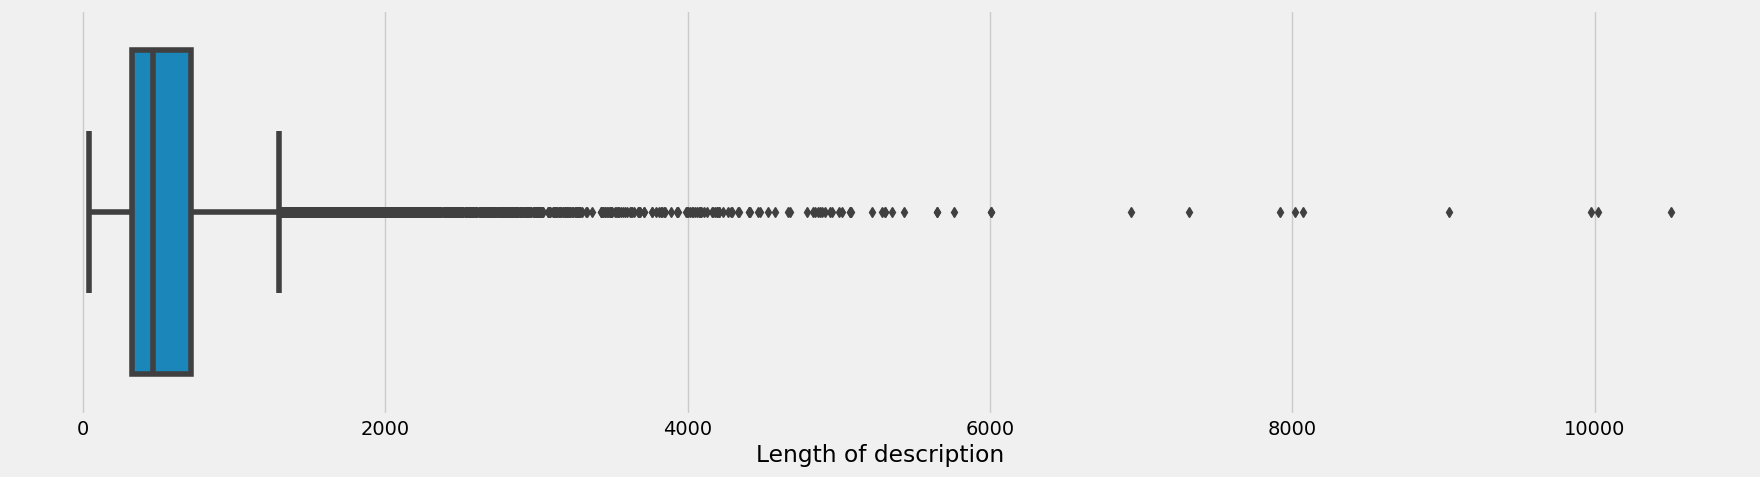

In [11]:
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data['description length'].values,hue='Genre',data=train_data)  # description length across all classes
plt.xlabel('Length of description')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=4000)
features = tfidf.fit_transform(train_data.Description).toarray()
labels = train_data.Genre
features.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_data['Description'], train_data['Genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
print(clf.predict(count_vect.transform(['''One year in the life of Albin and his family of shepherds in the North of Transylvania. In direct cinema style, this documentary follows their day to day routines, and their struggle to adapt to a new world where traditions are gradually replaced by modern values. Since joining the EU, Romania has been facing, like several other Eastern European countries, the pressure of mordern values, introducing in farmer's lives the cruel noyion of competition, the temptation of migrating to the higher salaries abroad, and the marginalizaation of the locally produced food against industrial products'''])))

In [ ]:
cv_df.groupby('model_name').accuracy.mean()